# Chapter 6 
 Modern Statistics: A Computer Based Approach with Python<br>
by Ron Kenett, Shelemyahu Zacks, Peter Gedeck

Publisher: Springer International Publishing; 1st edition (September 15, 2022) <br>
ISBN-13: 978-3031075650

(c) 2022 Ron Kenett, Shelemyahu Zacks, Peter Gedeck

The code needs to be executed in sequence.

Python packages and Python itself change over time. This can cause warnings or errors. We
"Warnings" are for information only and can usually be ignored. 
"Errors" will stop execution and need to be fixed in order to get results. 

If you come across an issue with the code, please follow these steps

- Check the repository (https://gedeck.github.io/mistat-code-solutions/) to see if the code has been upgraded. This might solve the problem.
- Check the errata at (https://gedeck.github.io/mistat-code-solutions/ModernStatistics/) and the issue tracker at https://github.com/gedeck/mistat-code-solutions/issues to see if the issue is known and a solution available.
- Report the problem using the issue tracker at https://github.com/gedeck/mistat-code-solutions/issues
- Paste the error message into Google and see if someone else already found a solution

In [1]:
import os
os.environ['OUTDATED_IGNORE'] = '1'
import warnings
from outdated import OutdatedPackageWarning
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=OutdatedPackageWarning)

# Time Series Analysis and Prediction

In [2]:
import datetime
import statsmodels.formula.api as smf
from statsmodels.tools.sm_exceptions import ValueWarning
import pandas as pd

import random
import numpy as np
import pingouin as pg
from scipy import stats
import matplotlib.pyplot as plt
import mistat

## The Components of a Time Series

To demonstrate the use of time series, we use a dataset of Covid deaths during a year

In [3]:
# Load the data
covid = pd.read_csv('COVID_DEATHS_DATE.csv.gz')

### Visualize the time series

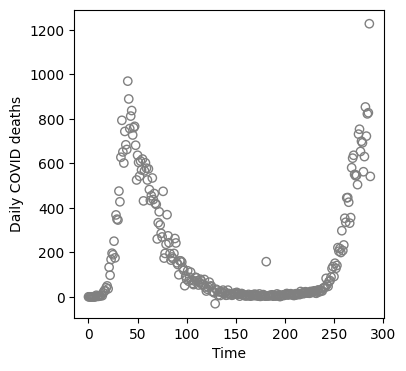

In [4]:
fig, ax = plt.subplots(figsize=[4, 4])
ax.scatter(list(covid.index), covid['deaths_daily'], facecolors='none', edgecolors='grey')
# ax.plot(t, ft, color='black')
ax.set_xlabel('Time')
ax.set_ylabel('Daily COVID deaths')
plt.show()

### Analyzing Time Series With Python

In [5]:
# convert Date column to Python datetime
dates = pd.to_datetime(covid['date'], format='%Y-%m-%d')
covid_ts = pd.Series(covid['deaths_daily'], name='Daily_COVID_deaths')
covid_ts.index = pd.DatetimeIndex(dates)

covid_ts.head()

date
2020-02-15    0
2020-02-16    0
2020-02-17    0
2020-02-18    0
2020-02-19    0
Name: Daily_COVID_deaths, dtype: int64

In [6]:
from statsmodels.tsa import tsatools
covid_df = tsatools.add_trend(covid_ts, trend='ct')
covid_df.head()

,Daily_COVID_deaths,const,trend
date,,,
2020-02-15,0,1.0,1.0
2020-02-16,0,1.0,2.0
2020-02-17,0,1.0,3.0
2020-02-18,0,1.0,4.0
2020-02-19,0,1.0,5.0


Intercept    226.623597
trend         -0.236029
dtype: float64
r2-adj: 0.002


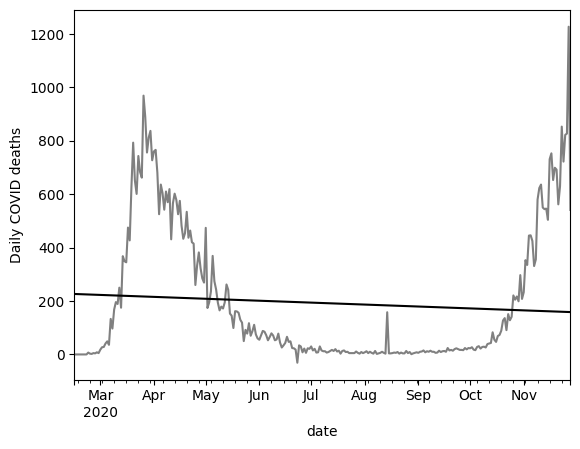

In [7]:
from statsmodels.tsa import tsatools
covid_df = tsatools.add_trend(covid_ts, trend='ct')
model_1 = smf.ols(formula='Daily_COVID_deaths ~ trend + 1', data=covid_df).fit()
print(model_1.params)
print(f'r2-adj: {model_1.rsquared_adj:.3f}')

ax = covid_ts.plot(color='grey')
ax.set_xlabel('Time')
ax.set_ylabel('Daily COVID deaths')
model_1.predict(covid_df).plot(ax=ax, color='black')
plt.show()

Try a cubic fit

Intercept        67.139757
I(trend ** 3)     0.000365
I(trend ** 2)    -0.137673
trend            12.169865
dtype: float64
r2-adj: 0.669


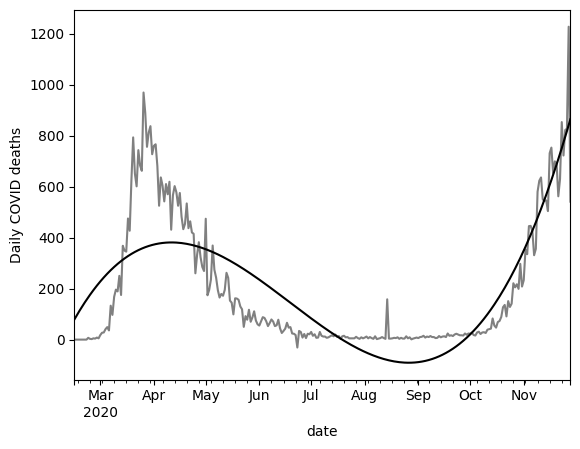

In [8]:
formula = 'Daily_COVID_deaths ~ I(trend**3) + I(trend**2) + trend + 1'
model_2 = smf.ols(formula=formula, data=covid_df).fit()
print(model_2.params)
print(f'r2-adj: {model_2.rsquared_adj:.3f}')

ax = covid_ts.plot(color='grey')
ax.set_xlabel('Time')
ax.set_ylabel('Daily COVID deaths')
model_2.predict(covid_df).plot(ax=ax, color='black')
plt.show()

Add month as an additional term for seasonal adjustment

Intercept        -210.154903
C(month)[T.3]     -32.838361
C(month)[T.4]    -268.369140
C(month)[T.5]    -653.175100
C(month)[T.6]    -662.536157
C(month)[T.7]    -505.122595
C(month)[T.8]    -335.236401
C(month)[T.9]    -281.700166
C(month)[T.10]   -364.654586
C(month)[T.11]   -308.865754
I(trend ** 3)       0.000555
I(trend ** 2)      -0.243513
trend              29.002361
dtype: float64
r2-adj: 0.836


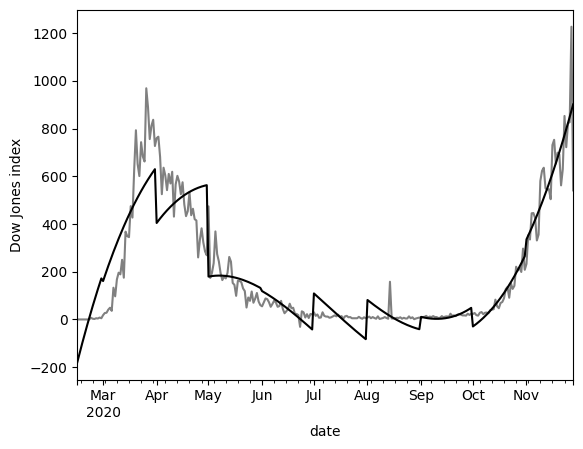

In [9]:
covid_df['month'] = covid_df.index.month
poly_formula = 'Daily_COVID_deaths ~ C(month) + I(trend**3) + I(trend**2) + trend + 1'
model_3 = smf.ols(formula=poly_formula, data=covid_df).fit()
print(model_3.params)
print(f'r2-adj: {model_3.rsquared_adj:.3f}')

ax = covid_ts.plot(color='grey')
ax.set_xlabel('Time')
ax.set_ylabel('Dow Jones index')
model_3.predict(covid_df).plot(ax=ax, color='black')
plt.show()

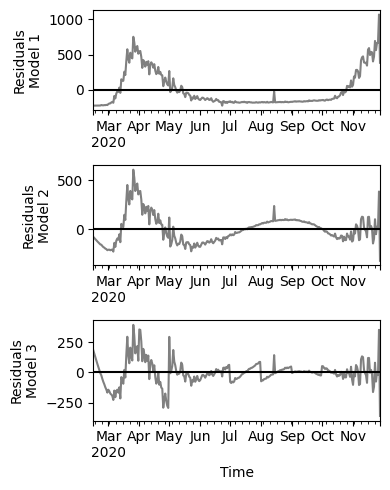

In [10]:
fig, axes = plt.subplots(figsize=[4, 5], nrows=3)
def residual_plot(model, ax, title):
  model.resid.plot(color='grey', ax=ax)
  ax.set_xlabel('')
  ax.set_ylabel(f'Residuals\n{title}')
  ax.axhline(0, color='black')
residual_plot(model_1, axes[0], 'Model 1')
residual_plot(model_2, axes[1], 'Model 2')
residual_plot(model_3, axes[2], 'Model 3')
axes[2].set_xlabel('Time')
plt.tight_layout()
plt.show()

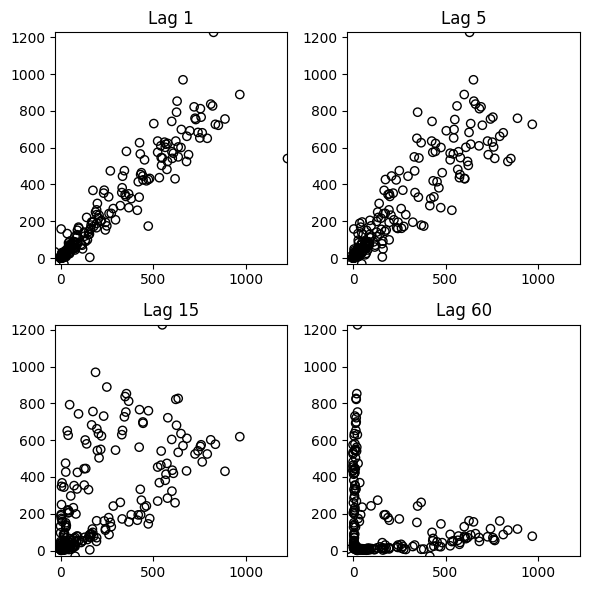

In [11]:
def plotLag(ts, lag, ax, limits):
  ax.scatter(ts[:-lag], ts[lag:], facecolors='none', edgecolors='black')
  ax.set_title(f'Lag {lag}')
  ax.set_xlim(*limits)
  ax.set_ylim(*limits)

fig, axes = plt.subplots(figsize=[6, 6], nrows=2, ncols=2)
limits = [covid_ts.min(), covid_ts.max()]
plotLag(covid_ts, 1, axes[0][0], limits)
plotLag(covid_ts, 5, axes[0][1], limits)
plotLag(covid_ts, 15, axes[1][0], limits)
plotLag(covid_ts, 60, axes[1][1], limits)

plt.tight_layout()
plt.show()

## Covariance Stationary Time Series

### Moving Averages

### Auto-Regressive Time Series

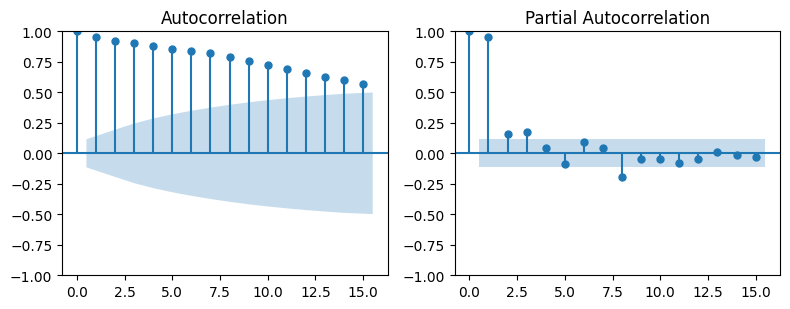

In [12]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

dow_acf = acf(covid_ts, nlags=15, fft=True)
dow_pacf = pacf(covid_ts, nlags=15)

fig, axes = plt.subplots(ncols=2, figsize=[8, 3.2])
plot_acf(covid_ts, lags=15, ax=axes[0])
plot_pacf(covid_ts, lags=15, method='ywm', ax=axes[1])
plt.tight_layout()
plt.show()

In [13]:
print(f'  k     rho(k)    rho*(k)')
for i, (v1, v2) in enumerate(zip(dow_acf, dow_pacf)):
  print(f'{i:3d}   {v1:8.4f}   {v2:8.4f}')

  k     rho(k)    rho*(k)
  0     1.0000     1.0000
  1     0.9498     0.9531
  2     0.9174     0.1683
  3     0.9003     0.1920
  4     0.8815     0.0492
  5     0.8517    -0.0957
  6     0.8351     0.0990
  7     0.8219     0.0505
  8     0.7864    -0.2166
  9     0.7535    -0.0619
 10     0.7258    -0.0633
 11     0.6928    -0.0949
 12     0.6553    -0.0571
 13     0.6276     0.0093
 14     0.6004    -0.0178
 15     0.5654    -0.0307


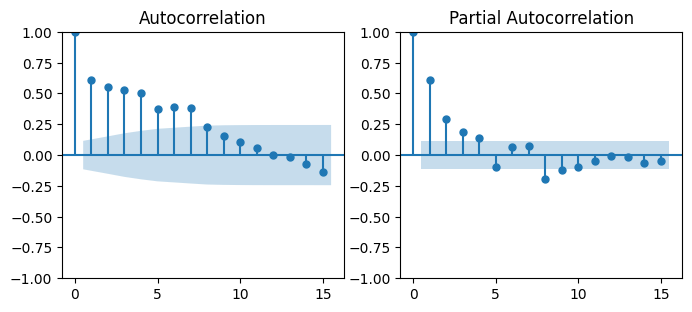

In [14]:
dow_acf = acf(model_3.resid, nlags=15, fft=True)
fig, axes = plt.subplots(ncols=2, figsize=[8, 3.2])
plot_acf(model_3.resid, lags=15, ax=axes[0])
plot_pacf(model_3.resid, lags=15, method='ywm', ax=axes[1])
plt.show()

In [15]:
print(f'  k     rho(k)')
for i, v1 in enumerate(dow_acf):
  print(f'{i:3d}   {v1:8.4f}')

  k     rho(k)
  0     1.0000
  1     0.6057
  2     0.5548
  3     0.5251
  4     0.5041
  5     0.3767
  6     0.3886
  7     0.3811
  8     0.2307
  9     0.1564
 10     0.1087
 11     0.0589
 12    -0.0009
 13    -0.0169
 14    -0.0760
 15    -0.1396


### Applications with Python

In [16]:
# ignore ValueWarning for Kurtosis-test due to small dataset
import warnings
warnings.simplefilter('ignore', category=(ValueWarning, UserWarning))

Best model: (4, 0, 4)


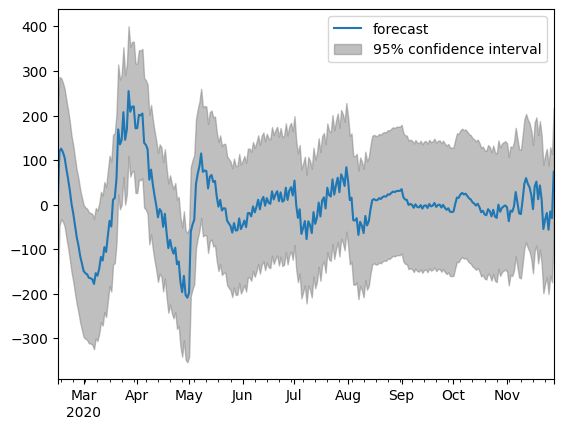

In [17]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict

# Identify optimal ARMA options using the AIC score
bestModel = None
bestAIC = None
for ar in range(0, 5):
  for ma in range(0, 5):
    model = ARIMA(model_3.resid, order=(ar, 0, ma)).fit()
    if bestAIC is None or bestAIC > model.aic:
      bestAIC = model.aic
      bestModel = (ar, 0, ma)
print(f'Best model: {bestModel}')

model = ARIMA(model_3.resid, order=bestModel).fit()

prediction = model.get_forecast(30).summary_frame()
prediction['date'] = [max(covid_ts.index) + datetime.timedelta(days=i)
                      for i in range(1, len(prediction) + 1)]

plot_predict(model)
ax = plt.gca()

ax.plot(prediction['date'], prediction['mean'])
ax.fill_between(prediction['date'],
                prediction['mean_ci_lower'], prediction['mean_ci_upper'],
                color='lightgrey')
plt.show()

In [18]:
# restore default setting
warnings.simplefilter('default', category=ValueWarning)

## Linear Predictors for Covariance Stationary Time Series

### Optimal Linear Predictors

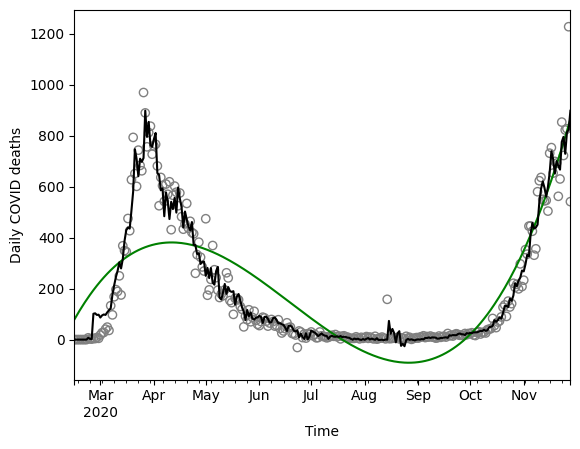

PMSE(trend) = 21177.1901
PMSE(corrected) = 3480.4495


In [19]:
predictedError = mistat.optimalLinearPredictor(model_2.resid,11,nlags=10)
predictedTrend = model_2.predict(covid_df)
correctedTrend = predictedTrend + predictedError

fig, ax = plt.subplots()
ax.scatter(covid_ts.index, covid_ts,
           facecolors='none', edgecolors='grey')
predictedTrend.plot(ax=ax, color='green')
correctedTrend.plot(ax=ax, color='black')
ax.set_xlabel('Time')
ax.set_ylabel('Daily COVID deaths')
plt.show()

print(f'PMSE(trend) = {np.mean((predictedTrend - covid_ts)**2):.4f}')
print(f'PMSE(corrected) = {np.mean((correctedTrend-covid_ts)**2):.4f}')

## Predictors for Non-Stationary Time Series

### Quadratic LSE Predictors

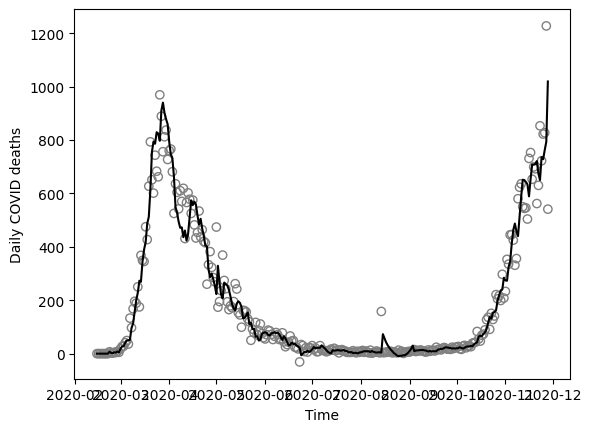

PMSE(quadratic) = 4875.5660


In [20]:
quadPrediction = mistat.quadraticPredictor(covid_ts, 20, 1)

fig, ax = plt.subplots()
ax.scatter(covid_ts.index, covid_ts,
           facecolors='none', edgecolors='grey')
ax.plot(covid_ts.index, quadPrediction, color='black')
ax.set_xlabel('Time')
ax.set_ylabel('Daily COVID deaths')
plt.show()

print(f'PMSE(quadratic) = {np.mean((quadPrediction-covid_ts)**2):.4f}')

### Moving Average Smoothing Predictors

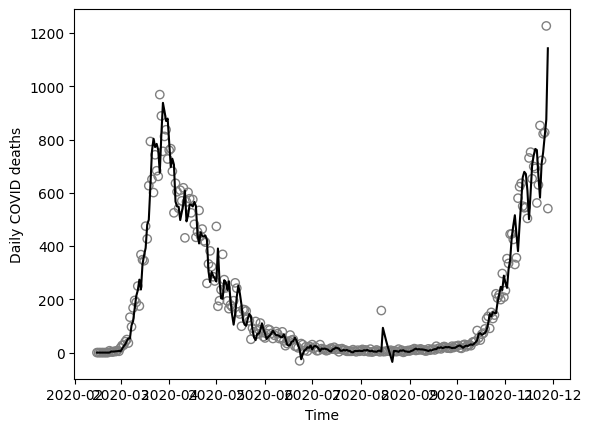

PMSE(MAS) = 5869.0729


In [21]:
masPrediction = mistat.masPredictor(covid_ts, 3, 1)

fig, ax = plt.subplots()
ax.scatter(covid_ts.index, covid_ts,
           facecolors='none', edgecolors='grey')
ax.plot(covid_ts.index, masPrediction, color='black')
ax.set_xlabel('Time')
ax.set_ylabel('Daily COVID deaths')
plt.show()

print(f'PMSE(MAS) = {np.mean((masPrediction - covid_ts)**2):.4f}')

## Dynamic Linear Models

### Some Special Cases

#### The Normal Random Walk

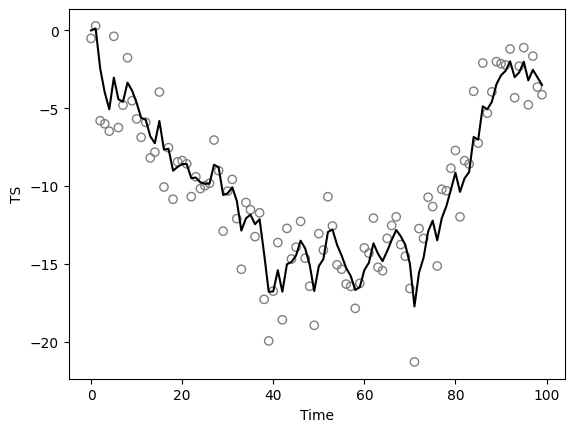

In [22]:
res = mistat.normRandomWalk(100, 3, 1, 1, seed=2)

fig, ax = plt.subplots()
ax.scatter(res.t, res.X, facecolors='none', edgecolors='grey')
ax.plot(res.t, res.predicted, color='black')
ax.set_xlabel('Time')
ax.set_ylabel('TS')

plt.show()

#### Dynamic Linear Model With Linear Growth

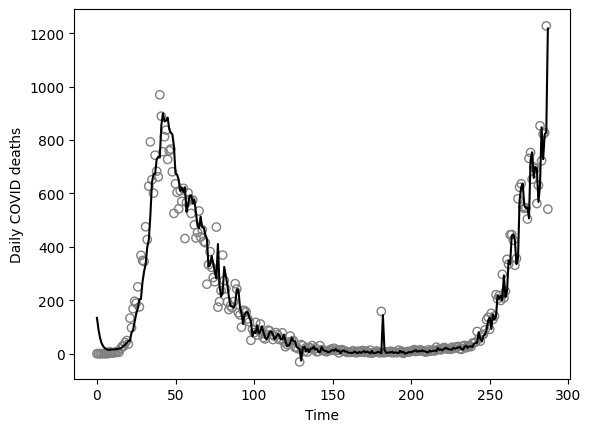

In [23]:
C0 = np.array([[0.22325, -0.00668], [-0.00668, 0.00032]])
M0 = np.array([134.234, -0.3115])
W = np.array([[0.3191, -0.0095], [-0.0095, 0.0004]])
v = 1

covid = pd.read_csv('../COVID_DEATHS.csv.gz', )
predicted = mistat.dlmLinearGrowth(covid['deaths_daily'].values, C0, v, W, M0)

fig, ax = plt.subplots()
ax.scatter(covid.index, covid, facecolors='none', edgecolors='grey')
ax.plot(covid.index, predicted, color='black')
ax.set_xlabel('Time')
ax.set_ylabel('Daily COVID deaths')
plt.show()

#### Dynamic Linear Model for ARMA(p,q)

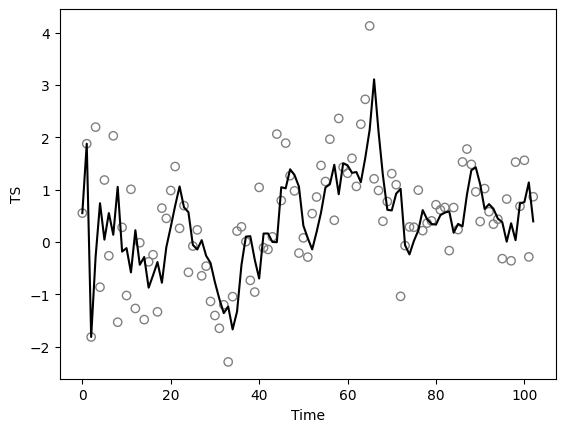

PMSE(ARMA) = 0.8505


In [24]:
a = [0.5, 0.3, 0.1]
b = [0.3, 0.5]
ts = pd.Series(mistat.simulateARMA(100, a, b, seed=1))
predicted = mistat.predictARMA(ts, a)

fig, ax = plt.subplots()
ax.scatter(ts.index, ts, facecolors='none', edgecolors='grey')
ax.plot(ts.index, predicted, color='black')
ax.set_xlabel('Time')
ax.set_ylabel('TS')
plt.show()

print(f'PMSE(ARMA) = {np.mean((predicted - ts)**2):.4f}')